In [1]:
#get_ipython().magic('reset -sf')

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy as sc
from scipy import ndimage
from IPython import get_ipython
%matplotlib inline

FIGURES_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/figures/working_memory_usage_model/'
SIMULATION_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/simulations/'
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    
import matplotlib as mpl
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functions.logProcess import logProcess
from functions.odeint import odeint

mpl.rcParams['axes.linewidth'] = 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

FIGURES_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/figures/'
SUP_FIG_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/sup_figures/'

# FUNCTIONS

In [2]:
def getStrWithNotZero(val, digits = 1):
    val = np.round(val, digits)
    val_str = str(val)
    
    for i in range(len(val_str)):
        if val_str[i] == '.':
            return val_str[i:]
        
    return val_str 

    
def defineInitialWeights(N, amp, sigma):
    
    if sigma == 0:
        wEE = amp*np.identity(N)
        return w1
    
    i = np.arange(0,N,1)
    j = np.arange(0,N,1)
    
    i,j = np.meshgrid(i,j)
    
    diff = np.abs(i - j)
    diff = np.stack([diff, N-diff])
    diff = np.min(diff, axis=0)
    
    wEE = amp * np.exp( -np.power( diff ,2 )/ (2*np.power( sigma, 2 )) )

    return wEE



def getInputProfile(N, i, amp, sigma):
    I = np.zeros(N)

    if sigma == 0:
        ix = i - (i//N)*N

        I[ix] = 1
        return I
    
    
    j = np.arange(0,N,1)
    diff = np.abs(j - i)
    diff = np.stack([diff, N-diff])
    diff = np.min(diff, axis=0)
    I = amp * np.exp( - np.power(diff, 2)/(2*(sigma**2)) )
    return I



def plotwEE(wEE):
    fig, axes = plt.subplots(1,2, figsize= (20,10))
    axes[0].set_title(r'$w_{EE}^{(ij)}$')
    wEE_im = axes[0].imshow(wEE, cmap = 'hot')
    
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="10%", pad=0.1)
    barwEE = plt.colorbar(wEE_im, cax=cax, ticks=[np.min(wEE), np.max(wEE)])
    
    axes[1].plot(wEE)
        
def flashingInput(N, num_input, time, time_step, on_phase = 0.5, off_phase = 0.5, sigma = 2):
    I = np.zeros([len(time), N])

    cell = np.zeros(num_input)
    
    
    for i in range(num_input):
        cell[i] = i - (i//N)*N
        
    
    
    for i in range(num_input-1):
        curr_cell = int(cell[i] + int(N/2))
        
        durationInput = int(on_phase/time_step)
        durationRest  = int(off_phase/time_step)
        min_ix = (durationRest + durationInput)*i
        max_ix = durationRest*i + durationInput*(i+1)
        
        I[min_ix:max_ix,:] = getInputProfile(N, curr_cell, 1, sigma)
        
    return I
    


# INTEGRATION OF SLEEP HOMEOSTASIS AND NAVIGATION CIRCUITS WITH FIXED CONNECTIONS


We asked how increasing activity in R5 neurons affects the head direction circuit in the absence of plasticity. Given the fact that R5 and wedge neurons are connected, we modeled a ring attractor network where wedge neurons encode head direction and R5 neurons provide increasing inhibitory input to wedge neurons. The model is shown schematically in Figure 2A and described by the following system of equations:

\begin{equation}
\begin{cases}\label{eq_ring_attractor_network}
    \tau \dot{r}_E^{(i)}(t) = - r_E^{(i)}(t) + \Big[ \sum_j^N w_{EE}^{(ij)}r_E^{(j)}(t) - w_{ER5}r_{R5} + \theta + I^{(i)}(m,t) \Big]_+  \quad\quad \text{for} \quad\quad i = 1,..., N \\
    \tau_{R5} \dot{r}_{R5}(t) = -r_{R5}(t) + \Big[ \sum_j^N w_{R5E}^{(j)}r_E^{(j)}(t) +  r_{ExR1}(t) \big]_+, \\
\end{cases}
\end{equation}

where $r_E(t)^{(i)}$ represents the activity of a wedge neuron $i$ (in total, $ N = 32$) and and $r_{R5}(t)$ is the population activity of R5 neurons and the time constants, $\tau_{R5}$ and $\tau$, are the same as in the sleep homeostasis model.
We only model the wake phase for simplicity, where dFB neurons are assumed to have zero activity and activity in ExR1 neurons is defined as $r_{ExR1}(t) = 1$, similar to the sleep homeostasis model.
We neglect the connection from wedge to ExR1 neurons for simplicity, since we focus on the interaction between wedge and R5 neurons. The weights $w_{AB}$ represent the connectivity from population $B$ to population $A$. The recurrent connectivity $w_{EE}^{(ij)}$ is a matrix, in which for a given presynaptic wedge neuron, $i$, the element $(ij)$ is given by a gaussian function that depends on the distance to the postsynaptic wedge neuron $j$ along the ring, given by equation

\begin{equation}\label{eq_w_ee_recurrent_connection_methods}
    w_{EE}^{(ij)} = w_{EE}^{(max)} \text{exp}\Bigg( - \frac{\Big(\text{min} \Big[|i-j|,\quad N - |i - j|\Big]\Big)^2}{2\sigma^2} \Bigg).
\end{equation}


This is how the weight matrix looks like

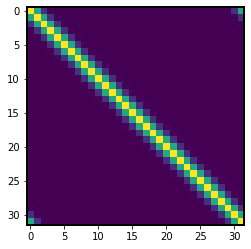

In [3]:
N = 32
wEE = defineInitialWeights(N, 1, 1)
plt.imshow(wEE)



In this model, the synaptic weight $w_{R5E}$ is tuned such that the activity of ring neurons increases, as in the sleep homeostasis model.

The following simulation shows a rotating input $I(m,t)$ is provided to wedge neurons at 0.5 Hz (top row, blue). The activity of R5 neurons increases, as imposed by our parameter choice (third row, red). The wedge neurons, (second row, green) follow the rotating input while receiving this increasing inhibition, such that the bump amplitude decreases over time until inhibition gets strong enough so that the bump vanishes.

### PARAMETERS 

In [161]:
####### PARAMS ########
N = 32
Imax   = 1
Isigma = 2

tau       = 0.01
tauR5     = 100


wINH = 0.25
theta = 10
wEI   = 30


rI_min = 0.1
rI_max = 0.6


wEE_max   = 0.3
wEE_sigma = 1.5

rHC = 1

In [162]:
def limit_m(m):
    if m >= N:
        m -= N
    if m < 0:
        m += N-1 
    return m


def limitPlasticityRuleToPositive(dwdt, w):
    ix = np.where(w <= 0)
    dwdt[ix] = np.clip(dwdt[ix], 0, None)
    return dwdt




def getSimulation(params, initial_conditions, max_time, time_step, log = True):
    tau, tauI, wINH,wEI,rHC, rI_min, rI_max, Imax, Isigma, rot_freq, N = params
    
    if not isinstance(rI_min, list):
        rI_min = [rI_min]*1000
        
    if not isinstance(rI_max, list):
        rI_max = [rI_max]*1000
    
    
    ###### Euler method parameters #########
    time = np.arange(0, max_time, time_step)
    
    
    ############e initial conditions ###########
    I = np.zeros([len(time), N])
    sleep = np.zeros(len(time), dtype = 'bool')
    sleep[0] = 0 # start with wake phase
    sleep_dep = np.zeros(len(time))
    
    
    count_wake_phase = 0
    m = np.zeros(len(time))
    m[0] = int(N/2)
    
    
    rE_0, rI_0, rH_0 = initial_conditions
    
    
    rE      = rE_0*  np.ones( N )
    rI      = rI_0*  np.ones( 1 )
    rH      = rH_0*  np.ones( 1 )
    
    wEE     = defineInitialWeights( N, amp = wEE_max, sigma = wEE_sigma ) 
 
    
    
    
    
    
    
    
    def ringAttractorOneRingNeuron(X, t, params):
        nonlocal count_wake_phase

        rE, rI, rH = X

        tau, tauI, wINH, wEI, rHC, rI_min, rI_max, Imax, Isigma, rot_freq, N, wEE, I, sleep, m, time_step   = params

        
        
        
        sleep[t] = 0


        if (count_wake_phase % 2) == 0:
            m[t] = m[t-1] + (rot_freq*N)*time_step

        if (count_wake_phase % 2) == 1:
            m[t] = m[t-1] - (rot_freq*N)*time_step    

        m[t] = limit_m(m[t])

        I[t] =  getInputProfile(N, int(m[t]), Imax, sigma=Isigma)

        if t*time_step > 10 and rI > rI_max[count_wake_phase]:
            sleep[t] = 1

        drHdt = (1./tau)*(-rH + rHC)



        drEdt = (1./tau) * ( - rE + np.clip( np.dot(wEE , rE) - wINH*np.sum(rE) -wEI*rI + theta + I[t]  , 0, None ) )
        drIdt = (1./tauI) * ( - rI +  rH + 0.05*np.sum(rE) )



        return [drEdt, drIdt, drHdt]
    
    
    
    
    
    
    
    params_simulation = params + [wEE, I, sleep, m, time_step]
    ##### simulation #####
    X0      = [rE, rI, rH]
    X, dXdt = odeint(ringAttractorOneRingNeuron, X0, time, params_simulation, log = log )
    
    print(count_wake_phase)
    return [time] + X, dXdt, params_simulation








In [163]:
rot_freq = 0.5

rI_min = [0.1]*10
rI_max = [0.6]*10

params = [tau, tauR5, wINH,wEI, rHC, rI_min, rI_max, Imax, Isigma, rot_freq, N]
initial_conditions = [0,rI_min[0], 0]
time_step = 0.001
X, dXdt, params = getSimulation(params, initial_conditions, max_time = 50, time_step = time_step, log=True)


0


In [166]:
def plotSolutionAnalysis(X, params, min_time, max_time, time_step, sigma, points = 10000, roll_bump = 0):
    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.0, 0.0)],

             'green': [(0.0,  0.1, 0.1),
                       (1, 1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)]}
    gfp = LinearSegmentedColormap('gfp', cdict, N=256, gamma=0.5)

    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)],

             'green':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)]}
    vis = LinearSegmentedColormap('vis', cdict, N=256, gamma=0.5)

    
    
    
    


    time, rE, rI, rH = X
    
    tau, tauI, wINH, wEI, rHC, rI_min, rI_max, Imax, Isigma, rot_freq, N, wEE, I, sleep, m, time_step   = params

    
    if max_time == -1:
        max_time = time[-1]
    
    min_ix = np.where(time > min_time)[0][0]
    max_ix = np.where(time < max_time)[0][-1]
    ix = np.linspace(min_ix, max_ix, points).astype(np.int)
    
    sleep   = sleep[ix]
    time    = time[ix]
    rE      = np.roll(rE[ix,:], roll_bump, axis = 1)
    rI      = rI[ix]
    rH      = rH[ix]
    I       = np.roll(I[ix,:], roll_bump, axis = 1)


    linewidth = 10
    
    
        
    fsize = 75
    plt.rcParams.update({'font.size': fsize})
    plt.rcParams['axes.linewidth'] = 7

    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(55, 40))
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(top=0.6)


    
    ################## sleep and wake areas in the top ###############
    
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[0].fill_between(time, 0, 1,
                 where=sleep == 1 ,
                 facecolor='black', alpha=0.2)
    
    axes[0].set_ylim([0,1])
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    axes[0].axis('off')

    
    
    
    
    
    ############# INPUT ###############
    imI = axes[1].imshow(I.transpose(), aspect='auto', cmap = vis, origin='lower', 
                         extent = (min_time, max_time, 0, N-1 ) )
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barI = plt.colorbar(imI, cax=cax, ticks=[0, Imax])
    barI.ax.set_yticklabels(['0', '$I_{max}$'])

    axes[1].set_yticks([])
    axes[1].set_ylabel('Input')


    axes[1].spines["bottom"].set_color("white")

    
    ################ BUMP ################
    axes[2].spines["top"].set_color("white")
    imrE = axes[2].imshow(rE.transpose(), aspect='auto', cmap = gfp, origin='lower', 
                         extent = (min_time, max_time, 0, N-1) )
    
    axes[2].set_ylabel('Bump')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barrE = plt.colorbar(imrE, cax=cax, ticks=[0, np.max(rE)])
    barrE.ax.set_yticklabels(['0', str(round(np.max(rE)))])
    axes[2].set_yticks([])


    ############ WEDGE NEURON 16 #############
    axes[3].plot(time, rE[:,16], color='green', linewidth = linewidth)
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[3].set_ylabel('$r_E^{(16)}(t)$')

    #axes[2].set_ylim([np.min(h[ix]) - 0.5*h_0, 2*h_0])

    plt.sca(axes[3])
    axes[3].yaxis.tick_right()
    plt.yticks([0, np.max(rE)], ['0', str(round(np.max(rE)))])
    plt.ylim(0,1.2*np.max(rE))
    axes[3].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')
    axes[3].set_xlim(min_time, max_time)

    
    
    ################# RING NEURONS ###############
    
    axes[4].plot(time, rI, color='red', linewidth = linewidth)
    divider = make_axes_locatable(axes[4])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[4].set_ylabel('$r_{R5}(t)$')
    plt.sca(axes[4])
    axes[4].yaxis.tick_right()
    plt.yticks([rI_min[0], rI_max[0]], [r'$r_I^{(min)}$', r'$r_I^{(max)}$'])
    axes[4].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')

    axes[4].axhline(rI_min[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")
    axes[4].axhline(rI_max[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")

    
    axes[4].set_xlim(min_time, max_time)
    axes[4].set_ylim([-0.1, 1.5*np.max(rI)])

        
    
    
            
    return axes



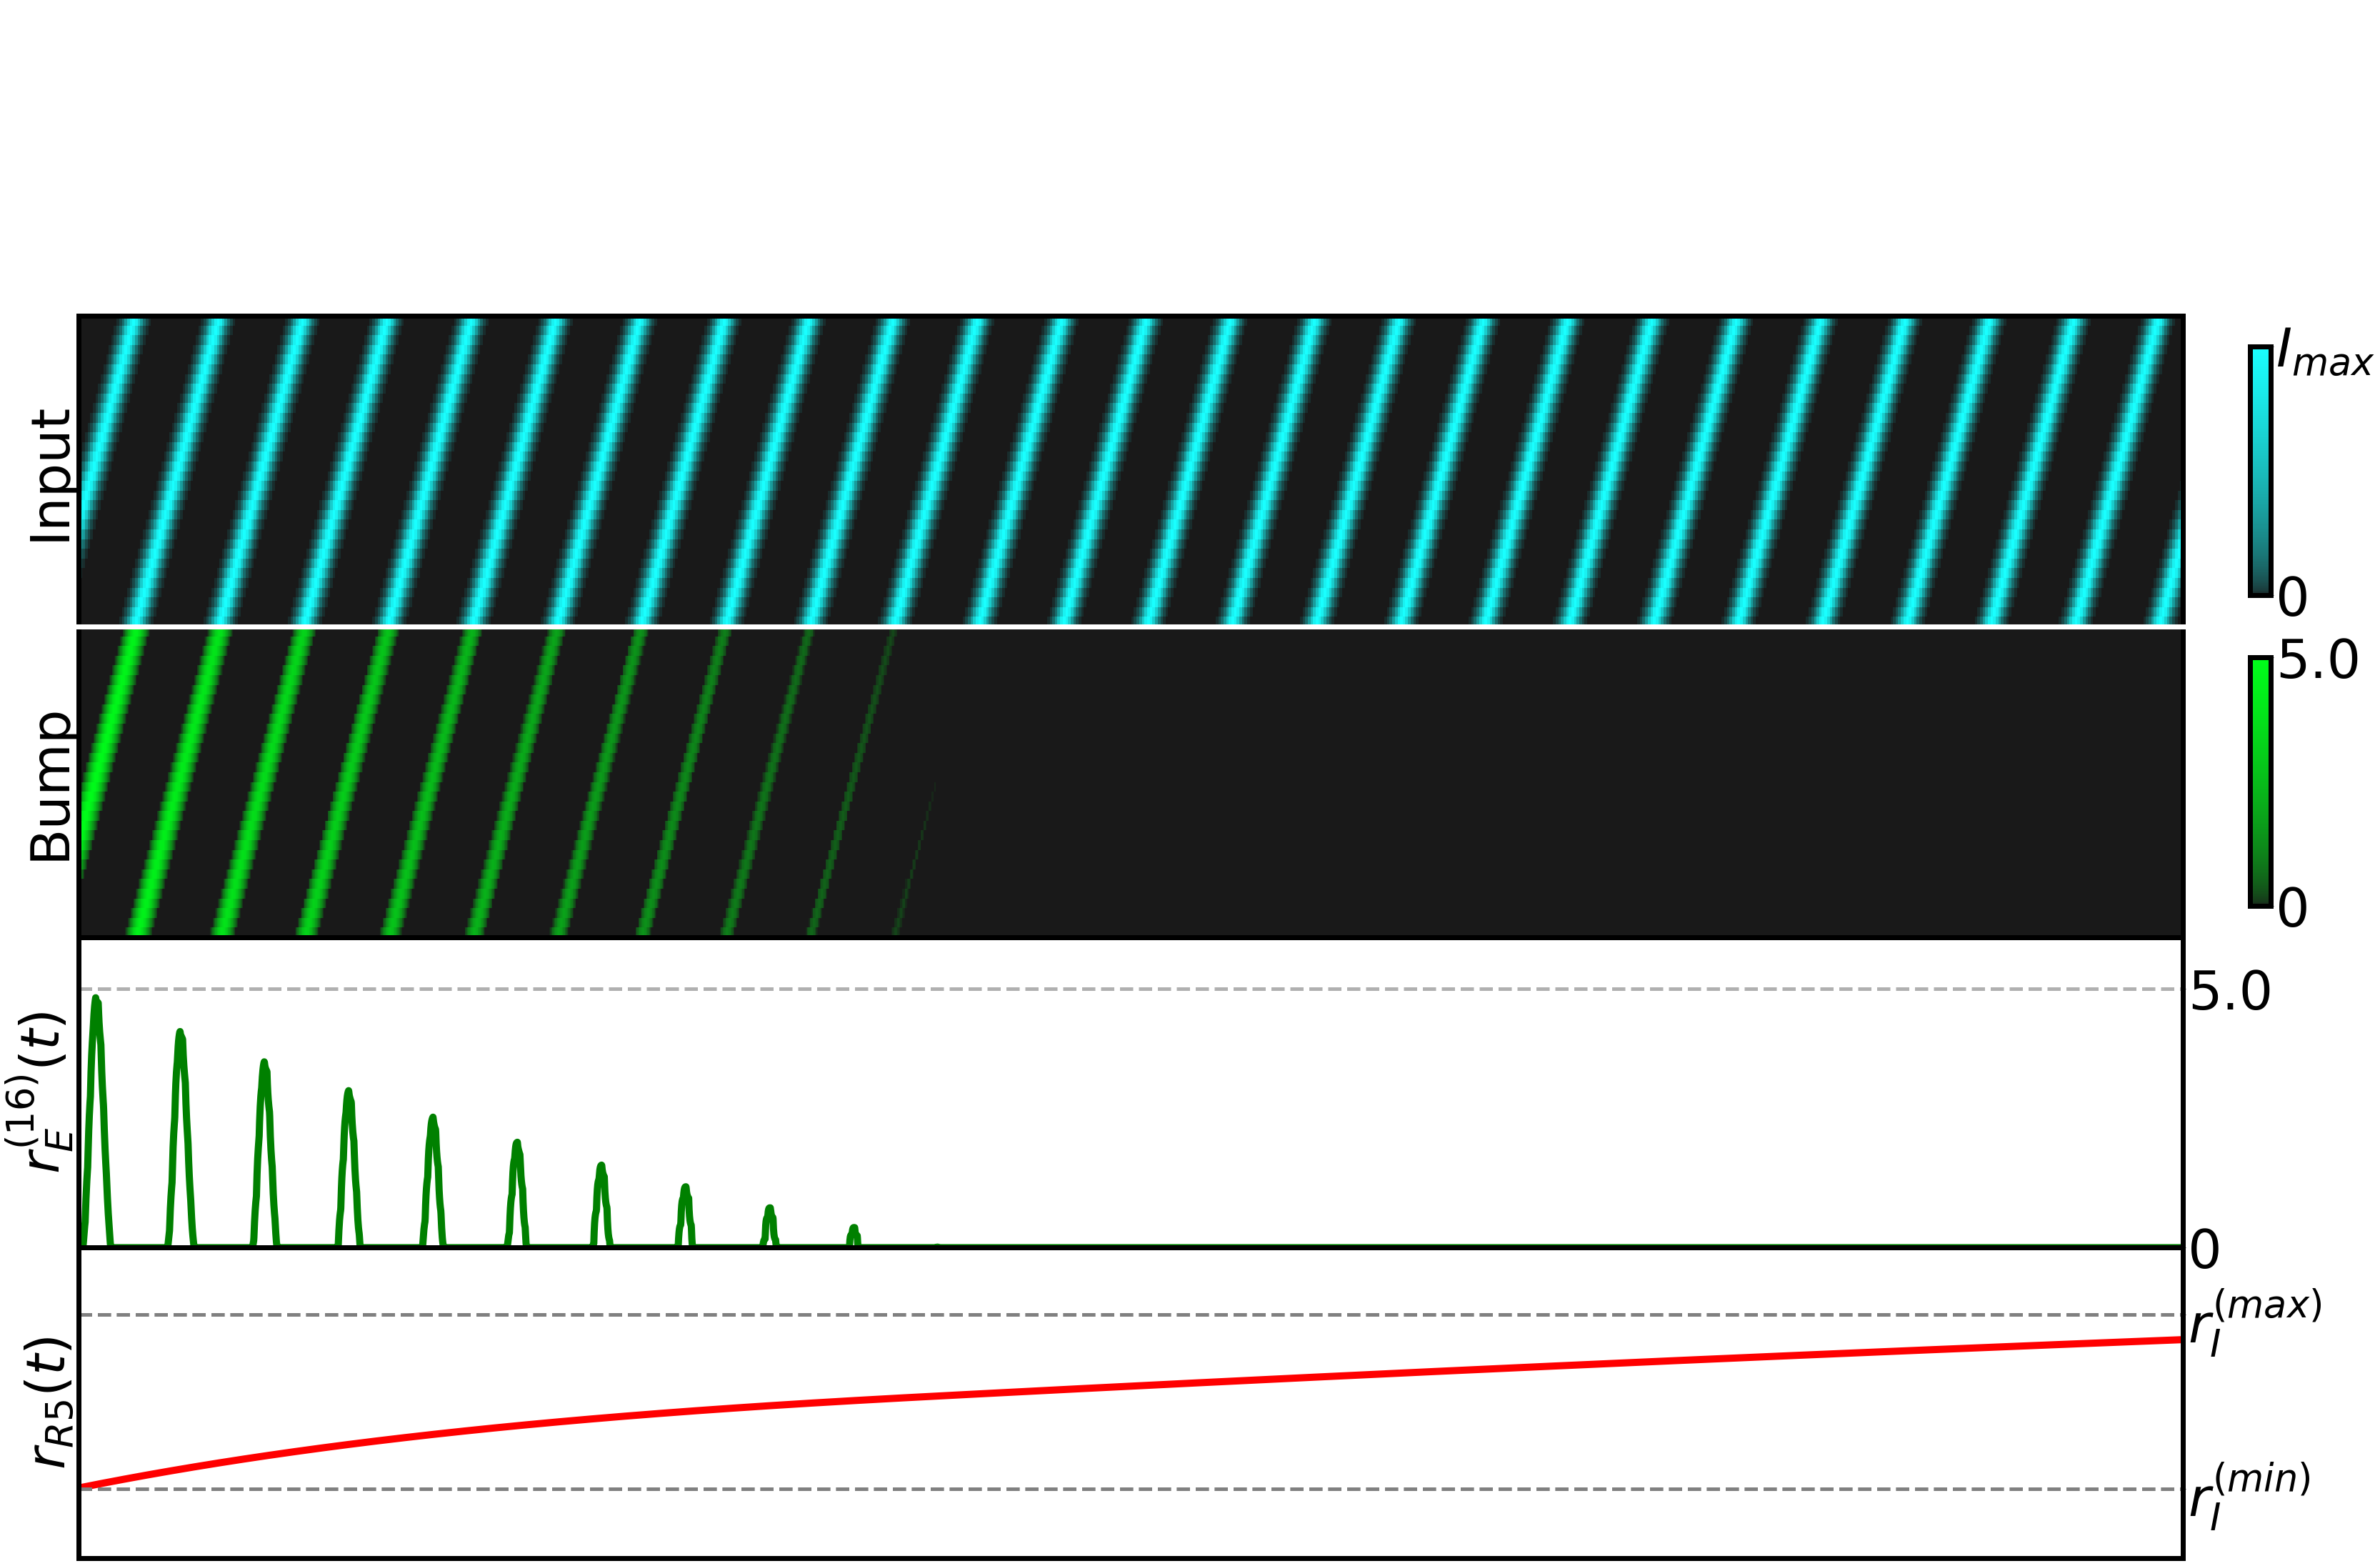

In [167]:
axes = plotSolutionAnalysis(X, params, min_time=0.1, max_time=-1, 
                     time_step=time_step, sigma=1.5,
                    roll_bump = -7)


fsize = 75
#axes[5].text(40, 1.2, r'$w_{EE}^{(16, sum)}$', color='white', fontsize= fsize)
#axes[6].text(160, 0.3, r'$w_{IE}^{(mean)}$', color='black', fontsize= fsize)

plt.savefig(FIGURES_DIR + '/sleep_homeostasis_model/vanishing_ring_attractor.svg', format = 'svg')



# INTEGRATION OF SLEEP HOMEOSTASIS AND NAVIGATION CIRCUITS WITH PLASTICITY

We add plastic connections in wedge neurons and between wedge and R5 neurons. The model is schematically shown in Figure 2D. The dynamics of the ring attractor network are given by the following equations:

\begin{equation}
\begin{cases}\label{eq_ring_attractor_network_methods}
    \tau \dot{r}_E^{(i)}(t) = - r_E^{(i)}(t) + \Big[ \sum_j^N w_{EE}^{(ij)}(t)r_E^{(j)}(t) - w_{EI}r_I(t) + \theta + I^{(i)}(m) \Big]_+  \quad\quad \text{for} \quad\quad i = 1,..., N \\
    \tau \dot{r}_I(t) = -r_I(t) + \Big[ \sum_j^N w_{IE}^{(j)}(t)r_E^{(j)}(t) \big]_+.
\end{cases}
\end{equation}

The synaptic plasticity rules are also extended to:

\begin{equation}\label{eq_ring_attractor_plasticity_rules_wake_methods}
\begin{cases}
    \tau_{EE} \dot{w}_{EE}^{(ij)}(t) =  cr_E^{(i)}(t) r_E^{(j)}(t) \quad\quad\quad\quad\quad \text{for} \quad\quad i,j = 1,..., N\\
    \tau_{IE} \dot{w}_{IE}^{(i)}(t) = cr_I(t)r_E^{(i)}(t)\Big(r_{E}^{(i)}(t) - r_0 \Big) \quad\quad \text{for} \quad\quad i = 1,..., N,
    \end{cases}
\end{equation}

In [168]:
####### PARAMS ########
N = 32
Imax   = 3.5
Isigma = 2

tau      = 0.01
tauEE   = 10000
tauIE   = 10000
tau_filt = 2


r0  = 10
wEI = 0.5
theta = 10

rI_min = 25
rI_max = 35


wEE_max   = 0.3
wEE_sigma = 1.5

In [169]:
def limit_m(m):
    if m >= N:
        m -= N
    if m < 0:
        m += N-1 
    return m


def limitPlasticityRuleToPositive(dwdt, w):
    ix = np.where(w <= 0)
    dwdt[ix] = np.clip(dwdt[ix], 0, None)
    return dwdt




def getSimulation(params, initial_conditions, max_time, time_step, log = True):
    tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N = params
    
    if not isinstance(rI_min, list):
        rI_min = [rI_min]*1000
        
    if not isinstance(rI_max, list):
        rI_max = [rI_max]*1000
    
    params = [tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N]
    
    ###### Euler method parameters #########
    time = np.arange(0, max_time, time_step)
    
    
    ############e initial conditions ###########
    I = np.zeros([len(time), N])
    sleep = np.zeros(len(time), dtype = 'bool')
    sleep[0] = 0 # start with wake phase
    sleep_dep = np.zeros(len(time))
    
    
    count_wake_phase = 0
    m = np.zeros(len(time))
    m[0] = int(N/2)
    
    
    rE_0, rI_0, wIE_0, wEE_max, wEE_sigma, rI_filt_0 = initial_conditions
    
    
    rE      = rE_0*  np.ones( N )
    rI      = rI_0*  np.ones( 1 )
    wEE     = defineInitialWeights( N, amp = wEE_max, sigma = wEE_sigma ) 
    wIE     = wIE_0* np.ones( N )
    rI_filt = rI_filt_0*np.ones(1)
    
    
    
    
    
    
    
    
    def ringAttractorOneRingNeuron(X, t, params):
        nonlocal count_wake_phase

        rE, rI, wEE, wIE, rI_filt = X

        tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N, I, sleep, m, time_step   = params

        
        
        
        if not sleep[t-1]:  #wake
            sleep[t] = 0
            dwEEdt =  (1./tauEE)*np.outer(rE, rE)

            if (count_wake_phase % 2) == 0:
                m[t] = m[t-1] + (rot_freq*N)*time_step

            if (count_wake_phase % 2) == 1:
                m[t] = m[t-1] - (rot_freq*N)*time_step    

            m[t] = limit_m(m[t])

            I[t] =  getInputProfile(N, int(m[t]), Imax, sigma=Isigma)

            if t*time_step > 10 and rI_filt > rI_max[count_wake_phase]:
                sleep[t] = 1




        elif sleep[t-1]:  #sleep
            sleep[t] = 1

            I[t] = 0
            dwEEdt =  -(1./tauEE)*np.outer(rE, rE)


            if  t*time_step > 10 and rI_filt < rI_min[count_wake_phase]:
                count_wake_phase += 1
                sleep[t] = 0
                m[t] = int(N/2)

        dwIEdt =  (1./tauIE)*rI*np.multiply(rE, rE - r0)

        #### clip plasticity rules to avoid negative values in the weights ####
        dwEEdt = limitPlasticityRuleToPositive(dwEEdt, wEE)
        dwIEdt = limitPlasticityRuleToPositive(dwIEdt, wIE)

        drEdt = (1./tau) * ( - rE + np.clip( np.dot(wEE , rE) - wEI*rI  + theta + I[t]  , 0, None ) )
        drIdt = (1./tau) * ( - rI + np.clip( np.sum(np.multiply(wIE, rE) ) , 0, None )  )

        drI_filtdt = (1./tau_filt) * ( - rI_filt + rI )



        return [drEdt, drIdt, dwEEdt, dwIEdt, drI_filtdt]
    
    
    
    
    
    
    
    params_simulation = params + [I, sleep, m, time_step]
    ##### simulation #####
    X0      = [rE, rI, wEE, wIE, rI_filt]
    X, dXdt = odeint(ringAttractorOneRingNeuron, X0, time, params_simulation, log = log )
    
    print(count_wake_phase)
    return [time] + X, dXdt, params_simulation








In [170]:
rot_freq = 0.5

rI_max = [35, 35, 40, 35,35, 35, 35]

params = [tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N]



initial_conditions = [0,0, 0.15, wEE_max, wEE_sigma, 23]
time_step = 0.0001
X, dXdt, params = getSimulation(params, initial_conditions, max_time = 100, time_step = time_step, log=True)


0


In [174]:
def plotSolutionAnalysis(X, params, min_time, max_time, time_step, sigma, points = 10000, roll_bump = 0):
    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.0, 0.0)],

             'green': [(0.0,  0.1, 0.1),
                       (1, 1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)]}
    gfp = LinearSegmentedColormap('gfp', cdict, N=256, gamma=0.5)

    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)],

             'green':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)]}
    vis = LinearSegmentedColormap('vis', cdict, N=256, gamma=0.5)

    
    
    
    


    time, rE, rI, rH = X
    
    tau, tauI, wINH, wEI, rHC, rI_min, rI_max, Imax, Isigma, rot_freq, N, wEE, I, sleep, m, time_step   = params

    
    if max_time == -1:
        max_time = time[-1]
    
    min_ix = np.where(time > min_time)[0][0]
    max_ix = np.where(time < max_time)[0][-1]
    ix = np.linspace(min_ix, max_ix, points).astype(np.int)
    
    sleep   = sleep[ix]
    time    = time[ix]
    rE      = np.roll(rE[ix,:], roll_bump, axis = 1)
    rI      = rI[ix]
    rH      = rH[ix]
    I       = np.roll(I[ix,:], roll_bump, axis = 1)


    linewidth = 10
    
    
        
    fsize = 75
    plt.rcParams.update({'font.size': fsize})
    plt.rcParams['axes.linewidth'] = 7

    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(55, 40))
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(top=0.6)


    
    ################## sleep and wake areas in the top ###############
    
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[0].fill_between(time, 0, 1,
                 where=sleep == 1 ,
                 facecolor='black', alpha=0.2)
    
    axes[0].set_ylim([0,1])
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    axes[0].axis('off')

    
    
    
    
    
    ############# INPUT ###############
    imI = axes[1].imshow(I.transpose(), aspect='auto', cmap = vis, origin='lower', 
                         extent = (min_time, max_time, 0, N-1 ) )
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barI = plt.colorbar(imI, cax=cax, ticks=[0, Imax])
    barI.ax.set_yticklabels(['0', '$I_{max}$'])

    axes[1].set_yticks([])
    axes[1].set_ylabel('Input')


    axes[1].spines["bottom"].set_color("white")

    
    ################ BUMP ################
    axes[2].spines["top"].set_color("white")
    imrE = axes[2].imshow(rE.transpose(), aspect='auto', cmap = gfp, origin='lower', 
                         extent = (min_time, max_time, 0, N-1) )
    
    axes[2].set_ylabel('Bump')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barrE = plt.colorbar(imrE, cax=cax, ticks=[0, 10])
    barrE.ax.set_yticklabels(['0', '$r_0$'])
    axes[2].set_yticks([])


    ############ WEDGE NEURON 16 #############
    axes[3].plot(time, rE[:,16], color='green', linewidth = linewidth)
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[3].set_ylabel('$r_E^{(16)}(t)$')

    #axes[2].set_ylim([np.min(h[ix]) - 0.5*h_0, 2*h_0])

    plt.sca(axes[3])
    axes[3].yaxis.tick_right()
    plt.yticks([0, 10], ['0', '$r_0$'])
    plt.ylim(0,1*np.max(rE))
    axes[3].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')
    axes[3].set_xlim(min_time, max_time)

    
    
    ################# RING NEURONS ###############
    print(rI_min, rI_max)
    axes[4].plot(time, rI, color='red', linewidth = linewidth)
    divider = make_axes_locatable(axes[4])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[4].set_ylabel('$r_{I}(t)$')
    plt.sca(axes[4])
    axes[4].yaxis.tick_right()
    plt.yticks([rI_min, rI_max], [r'$r_I^{(min)}$', r'$r_I^{(max)}$'])
    axes[4].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')

    axes[4].axhline(rI_min, color='grey', linewidth = linewidth/2, linestyle = "dashed")
    axes[4].axhline(rI_max, color='grey', linewidth = linewidth/2, linestyle = "dashed")

    
    axes[4].set_xlim(min_time, max_time)
    axes[4].set_ylim([rI_min-2, rI_max + 5])

        
    
    
            
    return axes



25 35


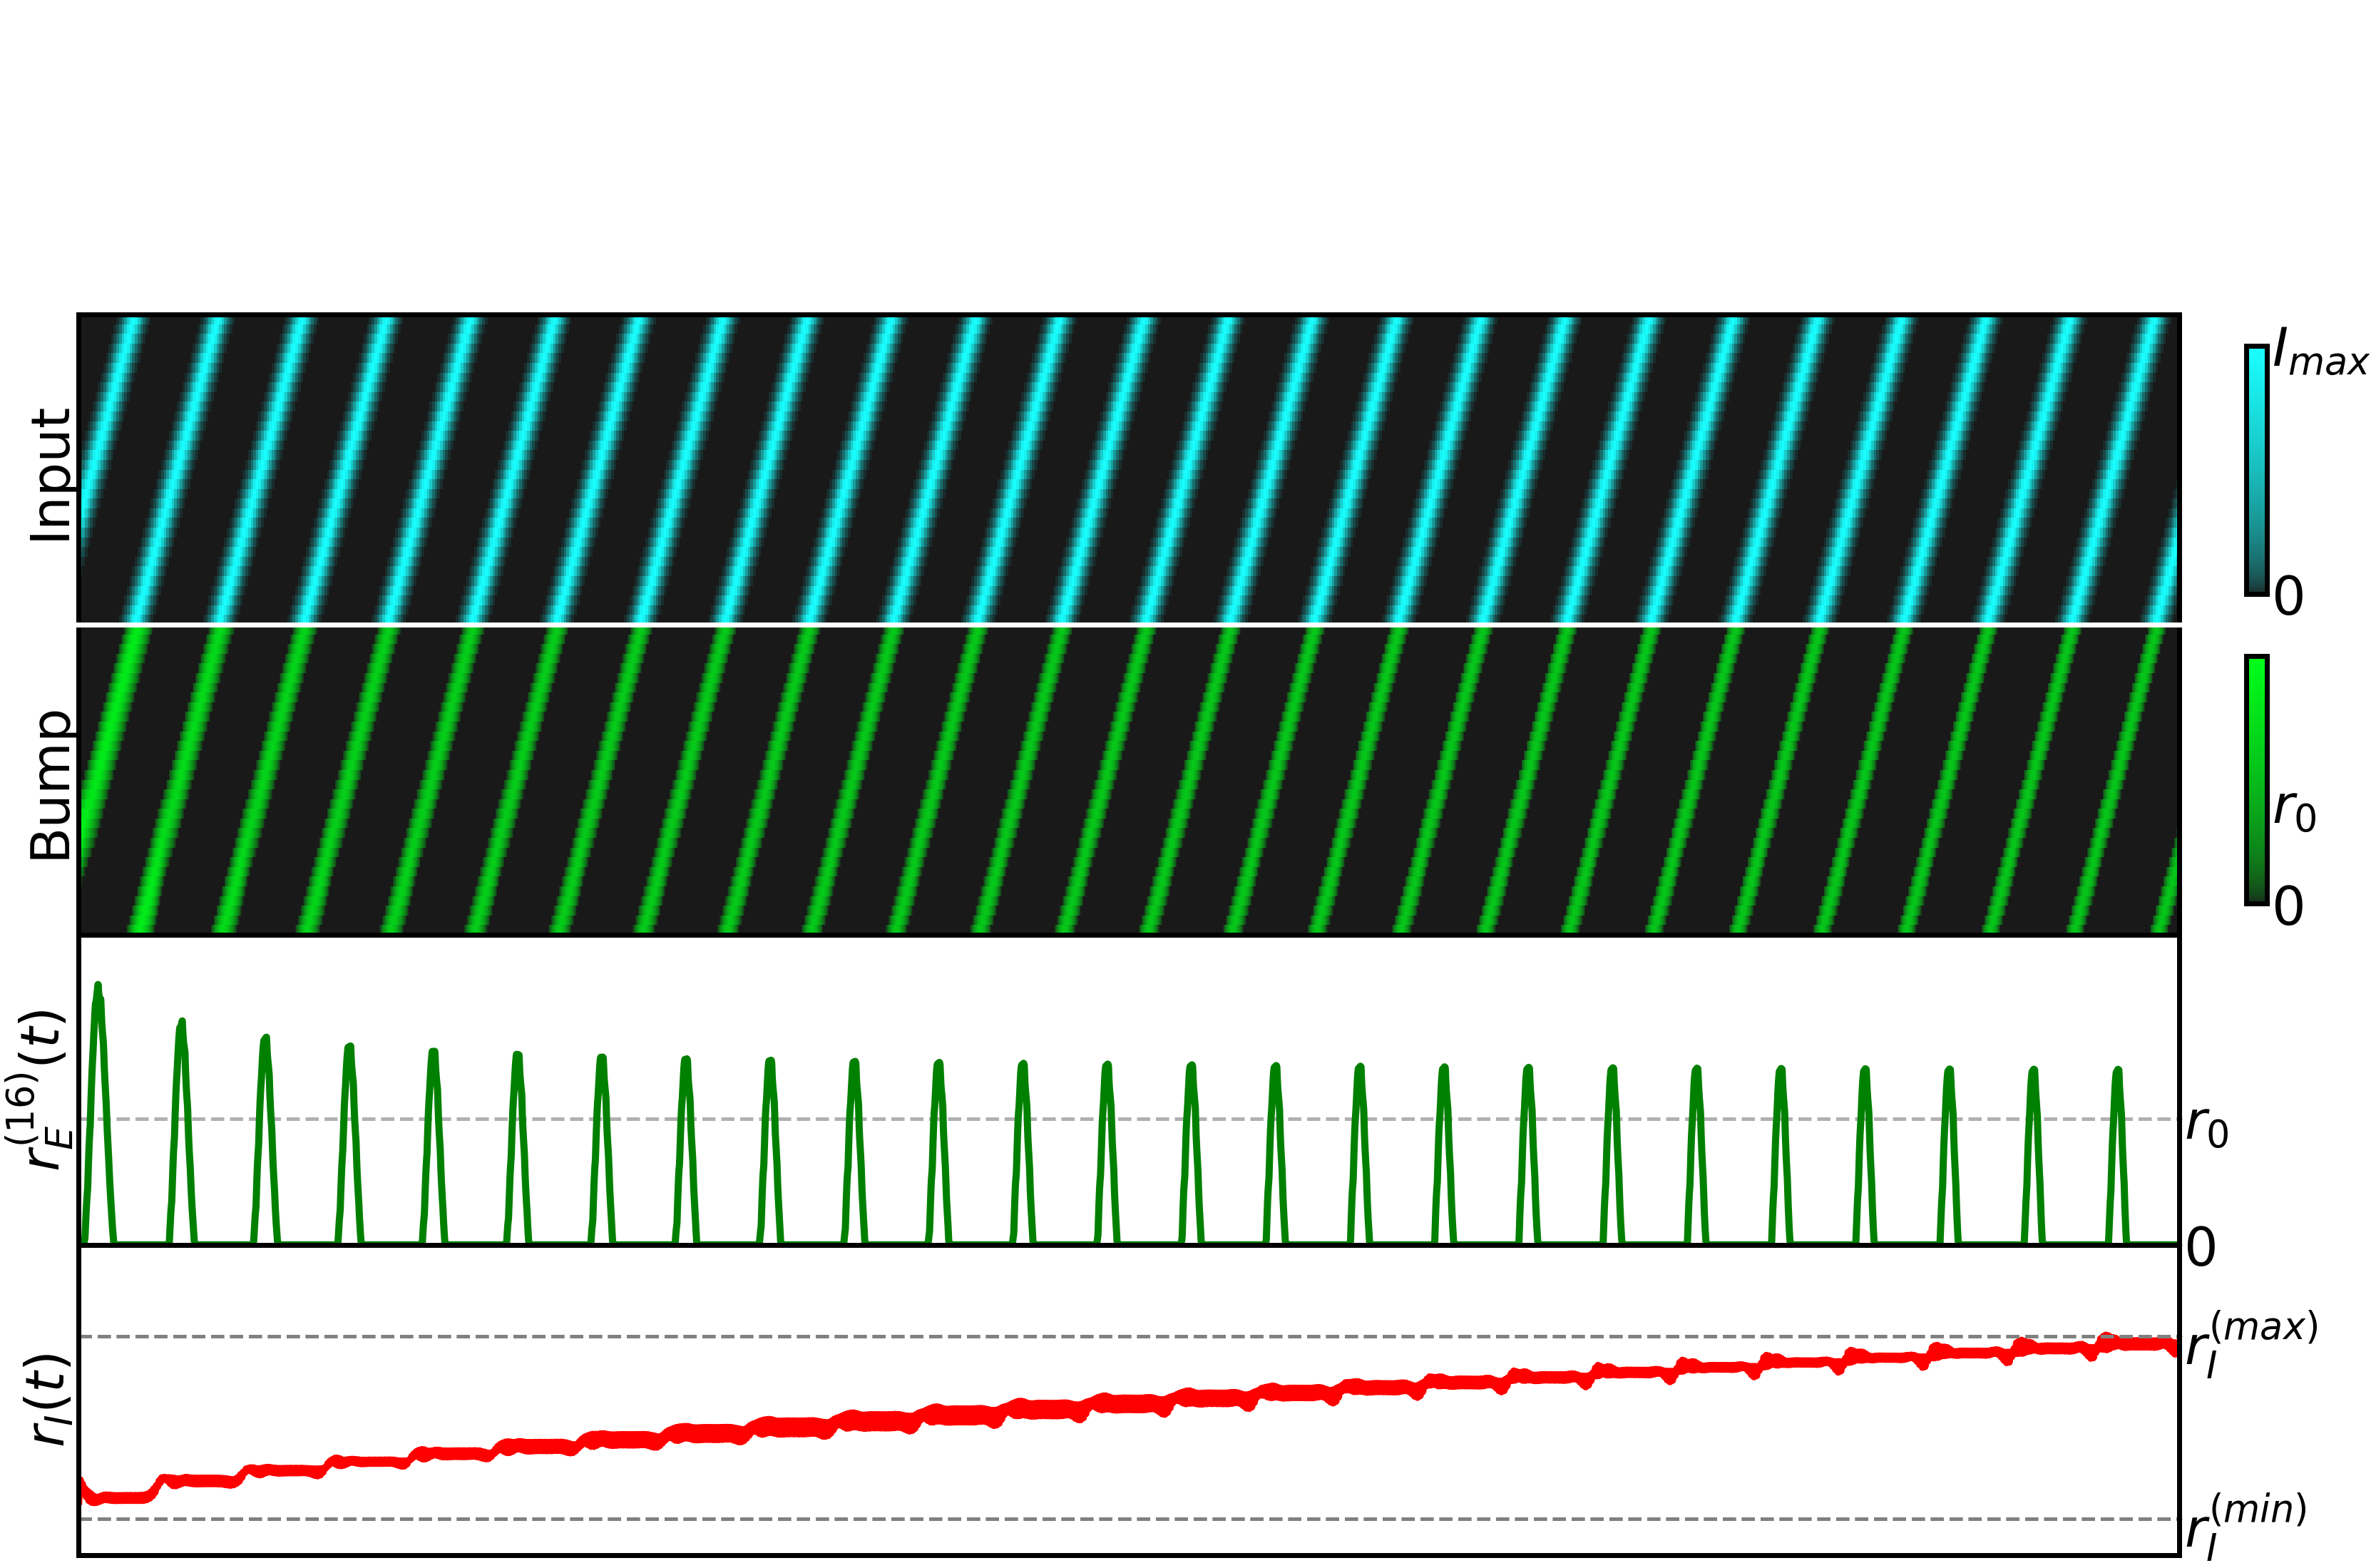

In [175]:
params_sim = [tau, tauI, wINH, wEI, rHC, rI_min, rI_max[0], Imax, Isigma, rot_freq, N, wEE, params[-4], params[-3], params[-2], params[-1]]

X_sim = [X[0], X[1], X[2], np.ones(len(X[0]))]
axes = plotSolutionAnalysis(X_sim, params_sim, min_time=0.1, max_time=50, 
                     time_step=time_step, sigma=1.5,
                    roll_bump = -7)


plt.savefig(FIGURES_DIR + '/sleep_homeostasis_model/ring_attractor_not_vanishing.svg', format = 'svg')
